# A practical case

In this practical case we have the monthly data of CO2 concentration retrieved by the Mauna Loa observatory in Hawaii since 1958. Data is expressed as a mole fraction in dry air, micromol/mol, abbreviated as ppm . Data is acquired from www.esrl.noaa.gov/gmd/ccgg/trends/ The problem is to forecast the CO2 concentration for the next 20 years.

Let us visualize the series,

In [4]:
import pandas as pd
df = pd.read_csv('co2_mm_mlo_series.csv',delimiter=";", header=None)
df.head()

,0,1
0,1958208,315.71
1,1958292,317.45
2,1958375,317.50
3,1958458,317.10
4,1958542,315.86


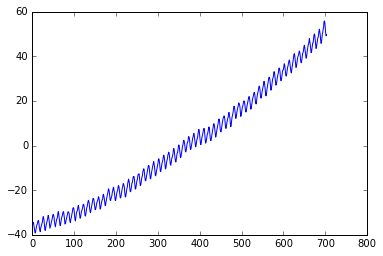

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

data=df.values
x = data[:,0].astype(float)
x = np.arange(0,x.shape[0])
y = data[:,1].astype(float)
mu = np.mean(y)
y = y - mu
plt.plot(x,y)

(704, 1) (704, 1) (900,)


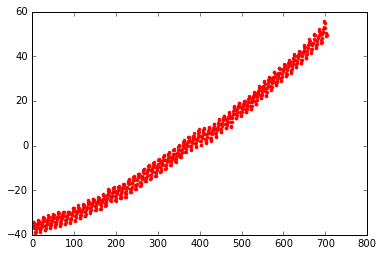

In [17]:
x_train = x.reshape((x.shape[0],1))
y_train = y.reshape((y.shape[0],1))

plt.plot(x_train.ravel(),y_train,'r.')

x_test = np.arange(0,900)  #Return evenly spaced values within a given interval. the original value was 900 instead of 703?
print x_train.shape, y_train.shape, x_test.shape

In [18]:
#GAUSSIAN PROCESS

import copy
from sklearn.base import BaseEstimator
import scipy.spatial.distance as distance

class GaussianProcess(BaseEstimator):
    def __init__(self,sigma_noise=0.01,covariance = None, arguments = None):
        '''l: is a vector of the scale for each dimension'''
        self.sigma_noise=sigma_noise
        self.covariance = covariance
        self.args = arguments
    
    def fit(self,X,y):
        self.X=X
        self.y=y
        A = self.covariance(self.X,self.X,**self.args)
        self.Ai = np.linalg.inv(A+self.sigma_noise*np.eye(A.shape[0]))
  
    
    def predict(self,X):
        B = self.covariance(X,self.X,**self.args).T
        C = self.covariance(X,X,**self.args)
        self.mu = np.dot(np.dot(B.T,self.Ai),self.y)  
        return self.mu
    
    def predict_proba(self,X):     
        B = self.covariance(X,self.X,**self.args).T
        C = self.covariance(X,X,**self.args)
        self.mu = np.dot(np.dot(B.T,self.Ai),self.y)
        self.cov = C - np.dot(np.dot(B.T,self.Ai),B)
        return  self.mu,np.diag(self.cov)
    
print 'DONE'

DONE


In [36]:
def linear_covariance(a,b,sigma1,sigma2):
    return sigma1*np.dot(a,b.T)+sigma2

def exponential_sine_covariance(a,b,l,p):    
    '''l: length scale p: periodicity'''
    r = a-b.T
    return np.exp(-2*np.sin(np.pi/p*r)**2/l)**2

def gaussian_covariance(a,b,l,s):                  
    d = distance.cdist(a,b,metric='seuclidean')      
    return s*np.exp(-0.5/l**2*d*d)  

def mykernel(a,b,l_sine,p_sine,l_g_sine,s_g_sine,l_g,s_g):
    cov1= gaussian_covariance(a,b,l = l_g,s = s_g)
    cov2= gaussian_covariance(a,b,l = l_g_sine, s = s_g_sine) + exponential_sine_covariance(a,b,l=l_sine,p=p_sine)
    cov3 = linear_covariance(a,b,1.,500.)
    return cov1+cov2 +cov3 

(704,) (704,)


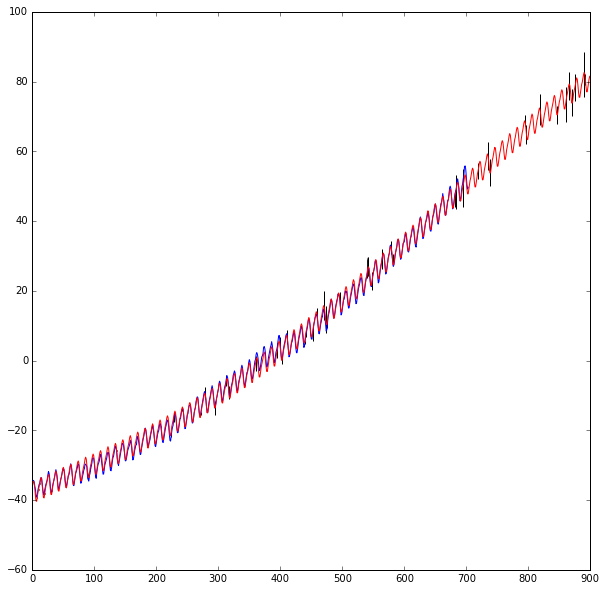

In [37]:
print x.shape, y.shape
__verbose__=False
l=0.01
sigma_noise=1e-4

A = np.exp(-0.5*(x_train-x_train.T)**2/l)
Ai = np.linalg.inv(A+sigma_noise*np.eye(A.shape[0]))
B = np.exp(-0.5*(x_train-x_test.T)**2/l)
C = np.exp(-0.5*(x_test-x_test.T)**2/l)

mu = np.dot(np.dot(B.T,Ai),y_train)
cov = C - np.dot(np.dot(B.T,Ai),B)

args = {'l_sine':np.array([1.]),'p_sine':1.44,\
        'l_g_sine':np.array([1.]),'s_g_sine':0.001,\
        'l_g':np.array([1.]),'s_g':0.0005}
gp = GaussianProcess(sigma_noise=1e-4,covariance=mykernel,arguments = args)

gp.fit(x_train,y_train)
f,c = gp.predict_proba(x_test[:,np.newaxis])

f_max = f.ravel() + 2*np.sqrt(c)
f_min = f.ravel() - 2*np.sqrt(c)


plt.figure(figsize=(10,10))
plt.plot(x_train.ravel(),y_train,'b-')
plt.plot(x_test.ravel(),f,'r-')
plt.fill_between(x_test, f_min, f_max, facecolor='lightgray', interpolate=True)